# Swissmetro test

Tests the ResLogit implementation

In [1]:
import dill as pickle
import pandas as pd
import pycmtensor as cmt
from pycmtensor.models import MNLogit, ResLogitLayer
from pycmtensor.optimizers import Adam
from pycmtensor.expressions import Beta, Weights
from pycmtensor.results import Results, Predict

cmt.logger.set_level(cmt.logger.WARNING)


In [2]:
swissmetro = pd.read_csv("data/swissmetro.dat", sep="\t")
db = cmt.Database(name="swissmetro", pandasDatabase=swissmetro, choiceVar="CHOICE")
globals().update(db.variables)
# Removing some observations
exclude = ((PURPOSE != 1) * (PURPOSE != 3) + (CHOICE == 0)) > 0
db.remove(exclude)

# additional steps to format database
db.data["CHOICE"] -= 1  # set the first choice to 0
db.choices = sorted(db.data["CHOICE"].unique())  # save original choices
db.autoscale(
    variables=["TRAIN_CO", "TRAIN_TT", "CAR_CO", "CAR_TT", "SM_CO", "SM_TT"],
    default=100.0,
    verbose=False,
)

In [3]:
# declare model params here
b_cost = Beta("b_cost", 0.0, None, None, 0)
b_time = Beta("b_time", 0.0, None, None, 0)
asc_train = Beta("asc_train", 0.0, None, None, 0)
asc_car = Beta("asc_car", 0.0, None, None, 0)
asc_sm = Beta("asc_sm", 0.0, None, None, 1)

W_1 = Weights("W_1", (3, 10), 0)
W_2 = Weights("W_2", (10, 3), 0)

U_1 = b_cost * db["TRAIN_CO"] + b_time * db["TRAIN_TT"] + asc_train
U_2 = b_cost * db["SM_CO"] + b_time * db["SM_TT"] + asc_sm
U_3 = b_cost * db["CAR_CO"] + b_time * db["CAR_TT"] + asc_car

# specify the utility function and the availability conditions
U = [U_1, U_2, U_3]
AV = [db["TRAIN_AV"], db["SM_AV"], db["CAR_AV"]]

# the reslogit layer
U = ResLogitLayer(U, W_1, W_2).output

mymodel = MNLogit(u=U, av=AV, database=db, name="mymodel")

mymodel.add_params(locals())

# set training configuration
mymodel.config["patience"] = 20000
mymodel.config["base_lr"] = 0.0012
mymodel.config["max_lr"] = 0.002
mymodel.config["learning_scheduler"] = "CyclicLR"
mymodel.config["cyclic_lr_step_size"] = 8
mymodel.config["cyclic_lr_mode"] = "triangular2"

In [4]:
# train function
model = cmt.train(
    mymodel, database=db, optimizer=Adam, batch_size=128, max_epoch=499, notebook=True
)

with open("myModel.pkl", "rb") as f:
    model = pickle.load(f)

result = Results(model, db, show_weights=True)
result.print_beta_statistics()
result.print_correlation_matrix()


dataset: swissmetro (n=6768)
batch size: 128
iterations per epoch: 52


Loglikelihood:  -7114.661  Score: 0.327

Epoch    0/25948:   0%|          | 0.00/25.9k [00:00<?, ?it/s]

[2022-03-14 17:36:41] WARNING: Maximum patience reached. Early stopping...


Optimization complete with accuracy of 62.160%. Max loglikelihood reached @ epoch 381.

Results for model: mymodel
Build time: 00:00:19
Estimation time: 00:00:48
Estimation rate: 8.013 epochs/s
Seed value: 5353
Number of Beta parameters: 4
Tensor size: 60
Sample size: 6768
Excluded data: 3960
Init loglikelihood: -7114.661
Final loglikelihood: -5291.533
Final loglikelihood reached at: epoch 381
Likelihood ratio test: 3646.257
Accuracy: 62.160%
Rho square: 0.256
Rho bar square: 0.247
Akaike Information Criterion: 10711.07
Bayesian Information Criterion: 11147.54
Final gradient norm: 0.312

Statistical Analysis:
              Value   Std err     t-test   p-value Rob. Std err Rob. t-test Rob. p-value
asc_car    0.186768  0.037372   4.997538  0.000001      0.05935    3.146888      0.00165
asc_train -0.337727  0.067522  -5.001743  0.000001     0.113001    -2.98872     0.002801
b_cost     0.021044  0.001675  12.564458       0.0     0.004845    4.343715     0.000014
b_time    -0.928362  0.0444

<Figure size 432x288 with 0 Axes>

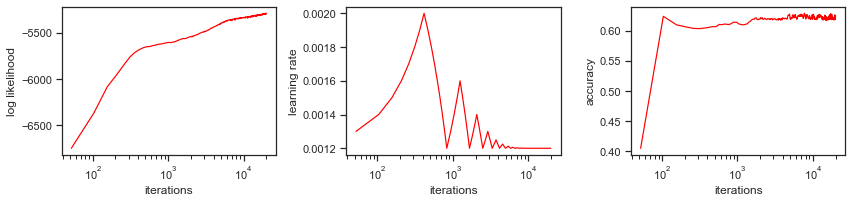

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.2})
sns.despine()
log = model.tracker.get_data()
fig, axs = plt.subplots(1, 3, figsize=(12, 3), squeeze=False)
g1 = sns.lineplot(ax=axs[0, 0], data=log, x=log.index, y="full_ll", color="red")
g2 = sns.lineplot(ax=axs[0, 1], data=log, x=log.index, y="lr", color="red")
g3 = sns.lineplot(
    ax=axs[0, 2], data=log, x=log.index, y="score", color="red"
)  # y = score or full_ll or lr
g1.set(xscale="log", xlabel="iterations", ylabel="log likelihood")
g2.set(xscale="log", xlabel="iterations", ylabel="learning rate")
g3.set(xscale="log", xlabel="iterations", ylabel="accuracy")
plt.tight_layout()
plt.savefig("docs/viz/fig2.png", format="png", facecolor="white", transparent=False)
plt.show()


The output file is available at docs/viz/print2.png


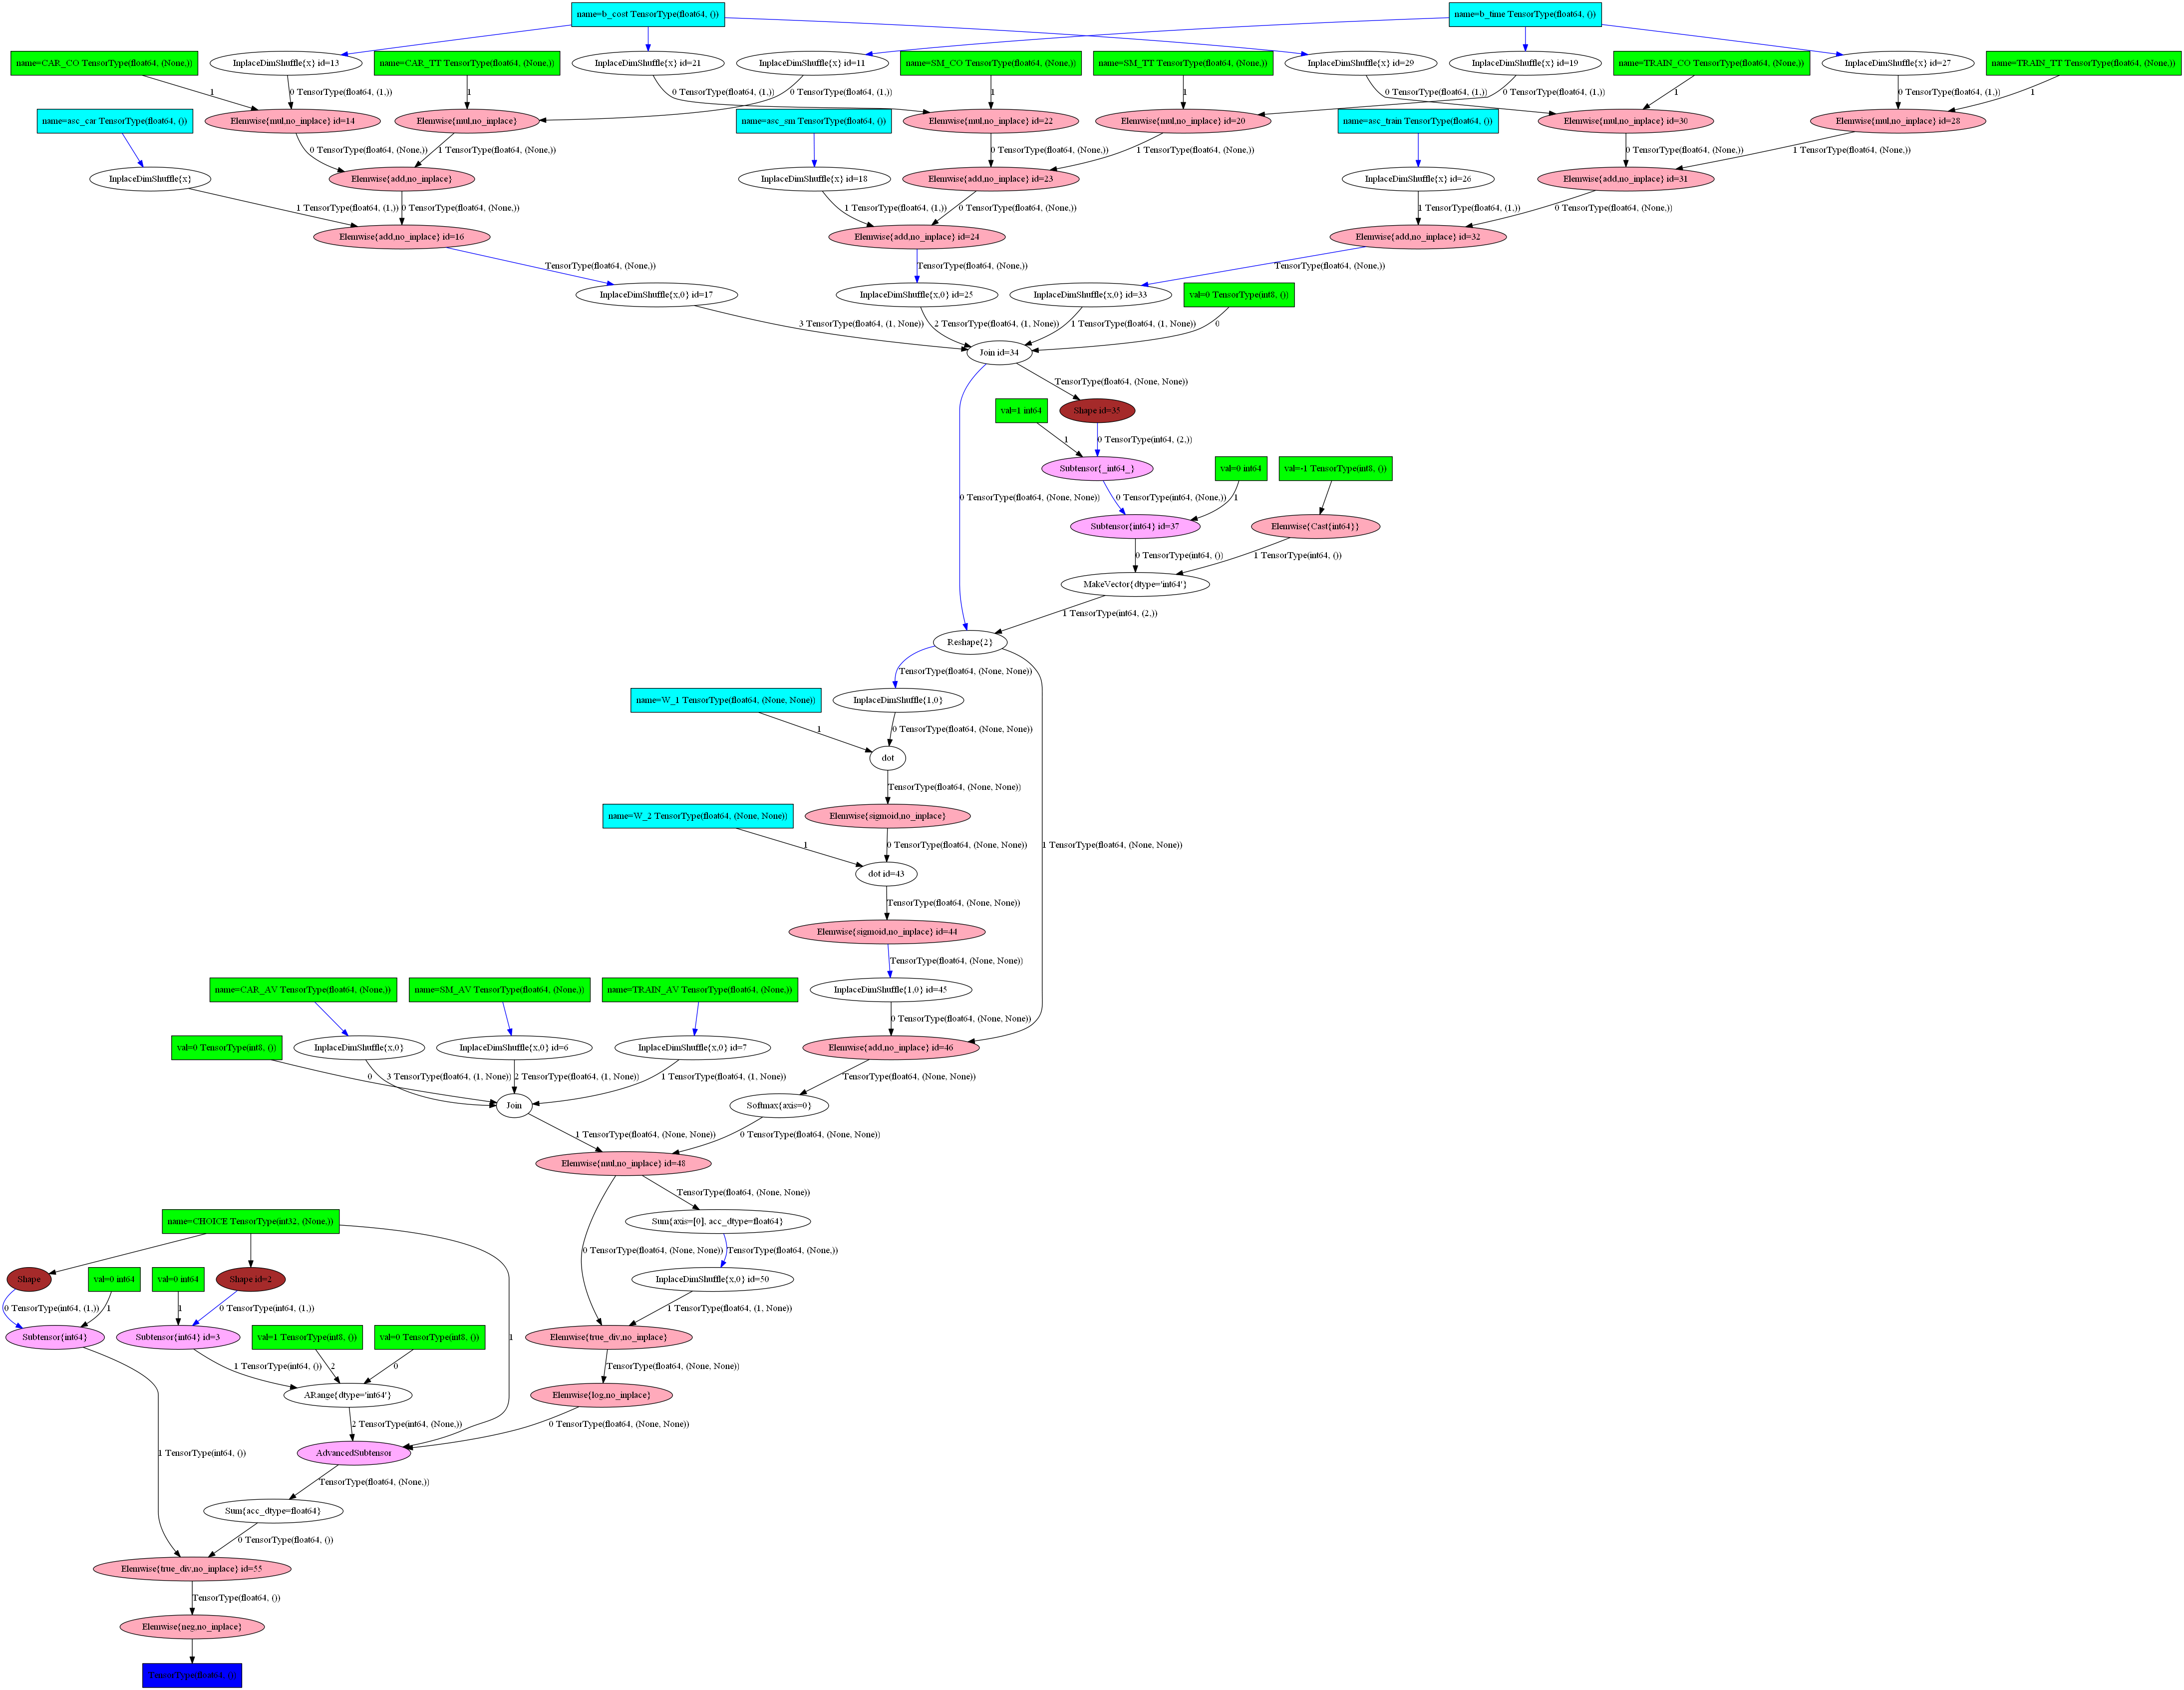

In [6]:
import aesara.d3viz as d3v
from aesara import printing
d3v.d3viz(model.loglikelihood, "docs/viz/ResLogit.html")
printing.pydotprint(mymodel.cost, "docs/viz/print2.png")
from IPython.display import Image
Image("docs/viz/print2.png", width="80%")


In [7]:
from pycmtensor.results import Predict
from pycmtensor.pycmtensor import PyCMTensorModel
import dill as pickle
import pandas as pd

class MNLmodel(PyCMTensorModel):
    def __init__(self, db):
        super().__init__(db)


with open("myModel.pkl", "rb") as f:
    model = pickle.load(f)

pd.concat((Predict(model, db).probs(), Predict(model, db).choices()), axis=1)


,0,1,2,CHOICE
0,0.108097,0.585455,0.306448,1
1,0.114732,0.591998,0.293270,1
2,0.095516,0.573670,0.330814,1
3,0.106169,0.455121,0.438709,1
4,0.092424,0.494253,0.413323,1
...,...,...,...,...
6763,0.110139,0.646193,0.243667,1
6764,0.106453,0.490725,0.402822,1
6765,0.108017,0.496344,0.395640,1
6766,0.097762,0.471883,0.430354,1
